# HLS In PYNQ

This simple notebook demonstrates using an HLS core in PYNQ. Our HLS core performs a simple 1D Filter operation with 9 filter coefficients. 

The HLS is below: 
``` C

#include "filt1d.hpp" // Defines C_NUM_COEFF and axis_t

/* filt1d - perform a 1-dimensional filtering operation on the array INPUT, and 
return the values in OUTPUT. Each value in OUTPUT is equal to the dot product of 
the coeff array, and a corresponding range of values in INPUT.*/
void filt1d(axis_t *INPUT, axis_t *OUTPUT,
    int coeff[C_NUM_COEFF], unsigned int length){
/* These two pragmas define the input and output ports as AXI-Stream (axis) interfaces.
   An AXI-Stream is FIFO-like, non-addressed communcation bus*/
#pragma HLS INTERFACE axis depth=50 port=INPUT
#pragma HLS INTERFACE axis depth=50 port=OUTPUT

/* These three pragmas define a new AXI-Lite bus named CTRL for the length, 
   coeff arguments, and HLS Status/Control registure (return)*/
#pragma HLS INTERFACE s_axilite port=coeff  bundle=CTRL
#pragma HLS INTERFACE s_axilite port=length bundle=CTRL
#pragma HLS INTERFACE s_axilite port=return bundle=CTRL
    /* This pragma creates an array of hardware registers for the input array coeff*/
#pragma HLS ARRAY_PARTITION COMPLETE variable=coeff

/* Next, we define our signal window. We will "shift" values out of the highest index, 
   and into the lowest index. We use a pragma to make window an array of hardware registers */
        int window[C_NUM_COEFF] = {0};
#pragma HLS ARRAY_PARTITION COMPLETE variable=window

    /* Sum is used to compute the dot product of the current window */
        int sum;
        axis_t cur;
/* The next three for loops implement the 1-D Filter operation. The outer for 
for loop reads values from the input array. The second for loop performs the shift 
operation on window, removing the oldest value, moving each value up, and putting 
the newest value in index 0. The third for loop performs the dot product operation 
between coeff and window. Pragmas are applied to maximize performance through 
pipelining and unrolling.*/
        for (unsigned int i = 0 ; i < length; i++) {
#pragma HLS PIPELINE
                for (unsigned int wi = C_NUM_COEFF-1; wi > 0; --wi){
#pragma HLS UNROLL
                        window[wi] = window[wi - 1];
                }
        cur = *INPUT++;
                window[0] = cur.data;
                sum = 0;
                for (unsigned int wi = 0; wi < C_NUM_COEFF; ++wi){
#pragma HLS UNROLL
                        sum += coeff[wi] * window[wi];
                }
        cur.data =sum;

                *OUTPUT++ = cur;
        }
}
```

The INPUT and OUTPUT arguments (streams) are connected to the Xilinx AXI DMA ENgine in the fabric

In [1]:
from pynqhls.stream import streamOverlay
overlay = streamOverlay('stream.bit')

In [2]:
signal = range(0, 1000)
coeffs = [1, 0, 0, 0, 0, 0, 0, 0, 0]
output = overlay.run(coeffs, signal)

test = [s == o for (s, o) in zip(signal, output)]

if False in test:
    print("Test Failed!")
else:
    print("Test Passed")

Test Passed


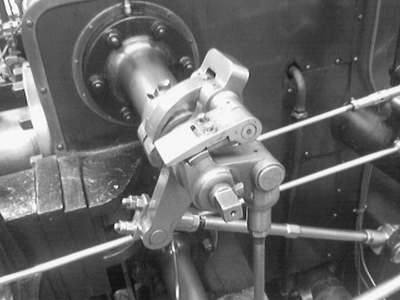

In [3]:
from PIL import Image
rgb = Image.open("pictures/valve.png")
bw = rgb.convert("L")
bw = bw.resize((400,300),Image.ANTIALIAS)
bw

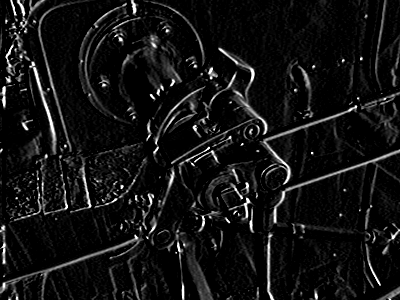

In [4]:
coeffs = [0, 0, -1, -2, 0, 2, 1, 0, 0]
sig = list(bw.getdata())
output = overlay.run(coeffs, sig)

out = Image.new(bw.mode, bw.size)
out.putdata(output)
out